In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
import random
import os
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [4]:
def visualize_random(folder):
    plt.figure(figsize=(20,10))
    images = os.listdir(folder)
    for i in range(10):
        img = random.choice([x for x in images])
        fig = plt.subplot(5, 5, i + 1)
        fig.axis('off')
        img = plt.imread(os.path.join(folder, img))
        fig.imshow(img)

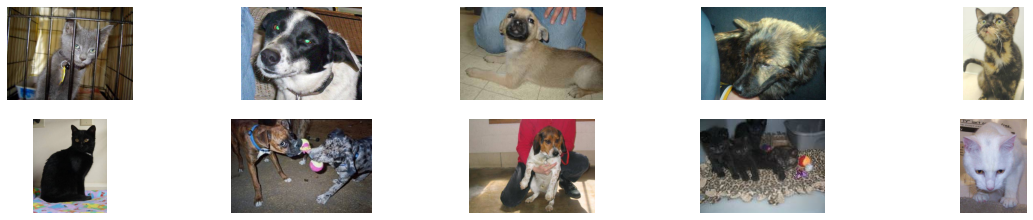

In [5]:
visualize_random('train')

In [ ]:
try:
    os.mkdir('total')
    for dir in ['training', 'validation']:
        path = os.path.join('total', dir)
        os.mkdir(path)
        for dir in ['cat', 'dog']:
            n_path = os.path.join(path, dir)
            os.mkdir(n_path)
except Exception:
    print('Existed!')

In [ ]:
cats = [x for x in os.listdir('train') if 'cat' in x]
dogs = [x for x in os.listdir('train') if 'dog' in x]
cat_test = random.sample(cats, int(0.2 * len(cats)))
dog_test = random.sample(dogs, int(0.2 * len(dogs)))

In [ ]:
for img in os.listdir('train'):
    src_img = os.path.join('train', img)
    if 'cat' in img:
        if img in cat_test:
            dst_img = os.path.join('total/validation/cat', img)
        else:
            dst_img = os.path.join('total/training/cat', img)
    elif 'dog' in img:
        if img in dog_test:
            dst_img = os.path.join('total/validation/dog', img)
        else:
            dst_img = os.path.join('total/training/dog', img)
    copyfile(src_img, dst_img)

In [7]:
gen_train = ImageDataGenerator(rescale=1/255,
                               rotation_range=40, 
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True, 
                               fill_mode='nearest')
gen_valid = ImageDataGenerator(rescale=1/255)

img_train = gen_train.flow_from_directory('total/training', target_size=(150, 150), batch_size=32, class_mode='binary')
img_valid = gen_valid.flow_from_directory('total/validation', target_size=(150, 150), batch_size=32, class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [9]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = Sequential([Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)), BatchNormalization(),
                        MaxPooling2D(2, 2), Dropout(0.25),
                        Conv2D(64, (3,3), activation='relu'), BatchNormalization(),
                        MaxPooling2D(2,2), Dropout(0.25),
                        Conv2D(128, (3,3), activation='relu'), BatchNormalization(),
                        MaxPooling2D(2,2), Dropout(0.25),
                        Flatten(),
                        Dense(128, activation='relu'), BatchNormalization(), Dropout(0.5),
                        Dense(1, activation='sigmoid')])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
____________________

In [10]:
history = model.fit(img_train, epochs=20, validation_data=img_valid)

Epoch 1/20
625/625 [==============================] - 600s 955ms/step - loss: 0.8153 - accuracy: 0.5721 - val_loss: 0.6264 - val_accuracy: 0.6556
Epoch 2/20
625/625 [==============================] - 618s 988ms/step - loss: 0.6096 - accuracy: 0.6669 - val_loss: 0.5769 - val_accuracy: 0.6972
Epoch 3/20
625/625 [==============================] - 612s 979ms/step - loss: 0.5523 - accuracy: 0.7111 - val_loss: 0.5549 - val_accuracy: 0.7152
Epoch 4/20
625/625 [==============================] - 560s 896ms/step - loss: 0.5337 - accuracy: 0.7307 - val_loss: 0.5585 - val_accuracy: 0.7432
Epoch 5/20
625/625 [==============================] - 613s 980ms/step - loss: 0.4980 - accuracy: 0.7555 - val_loss: 0.6729 - val_accuracy: 0.6966
Epoch 6/20
625/625 [==============================] - 556s 889ms/step - loss: 0.4616 - accuracy: 0.7850 - val_loss: 0.4465 - val_accuracy: 0.7926
Epoch 7/20
625/625 [==============================] - 613s 980ms/step - loss: 0.4574 - accuracy: 0.7887 - val_loss: 0.4755 -

In [11]:
df_hist = pd.DataFrame(history.history)
df_hist

,loss,accuracy,val_loss,val_accuracy
0,0.727292,0.60070,0.626411,0.6556
1,0.594162,0.67900,0.576901,0.6972
2,0.549844,0.71485,0.554897,0.7152
3,0.521830,0.74205,0.558539,0.7432
4,0.491172,0.75855,0.672924,0.6966
5,0.466561,0.77900,0.446513,0.7926
6,0.443381,0.79420,0.475506,0.7918
7,0.425996,0.80405,0.439679,0.7922
8,0.410946,0.81120,0.336803,0.8484
9,0.393859,0.82125,0.436073,0.7922


In [12]:
df_hist.to_csv('Modified.csv')

In [13]:
def convert_one_img(img_folder, img):
    img_width, img_height = 150, 150
    img = os.path.join(img_folder, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255
    return img

In [26]:
cat_images = os.listdir('total/validation/cat')
cat_result = []
for i, img in enumerate(cat_images):
    pic = convert_one_img('total/validation/cat', os.listdir('total/validation/cat')[i])
    label = 'Cat' if (model.predict(pic) < 0.5).astype('int') else 'Dog'
    cat_result.append(label)

In [27]:
dog_images = os.listdir('total/validation/dog')
dog_result = []
for i, img in enumerate(dog_images):
    pic = convert_one_img('total/validation/dog', os.listdir('total/validation/dog')[i])
    label = 'Cat' if (model.predict(pic) < 0.5).astype('int') else 'Dog'
    dog_result.append(label)

In [35]:
cat_images = os.listdir('total/validation/cat')
cat_value = []
for i, img in enumerate(cat_images):
    pic = convert_one_img('total/validation/cat', os.listdir('total/validation/cat')[i])
    cat_value.append(model.predict(pic))

In [39]:
dog_images = os.listdir('total/validation/dog')
dog_value = []
for i, img in enumerate(dog_images):
    pic = convert_one_img('total/validation/dog', os.listdir('total/validation/dog')[i])
    dog_value.append(model.predict(pic))

In [37]:
print(cat_result.count('Cat'), cat_result.count('Dog'))
print(dog_result.count('Cat'), dog_result.count('Dog'))

2372 128
553 1947


<AxesSubplot:>

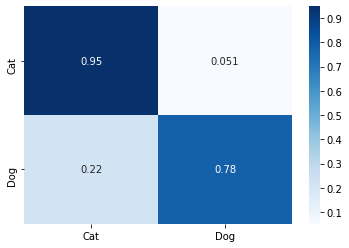

In [40]:
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

con_matrix = np.asarray([[2372, 128], [553, 1947]])/2500
sns.heatmap(con_matrix, annot=True, xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'], cmap='Blues')

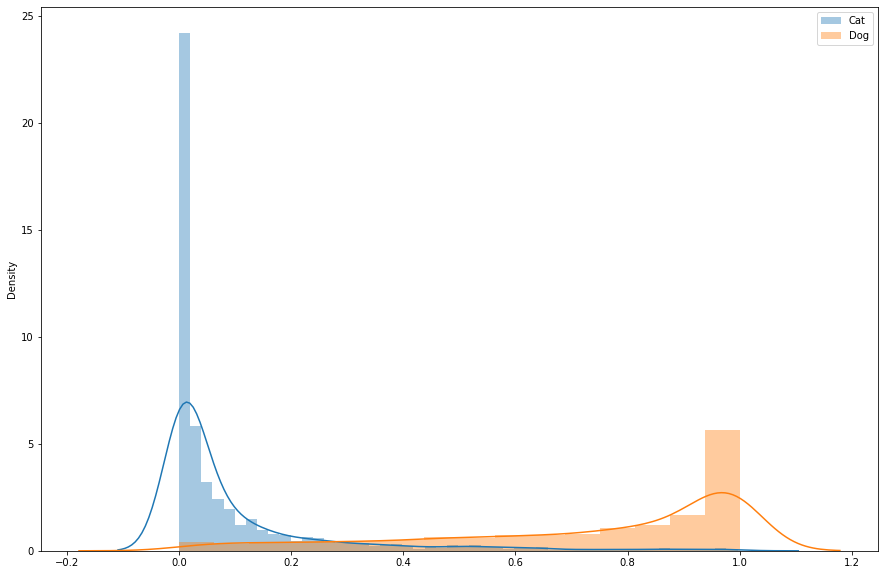

In [50]:
plt.figure(figsize=(15,10))
sns.distplot(cat_value, label='Cat')
sns.distplot(dog_value, label='Dog')
plt.legend()

In [46]:
cat_images = os.listdir('total/validation/cat')
cat_result_1 = []
for i, img in enumerate(cat_images):
    pic = convert_one_img('total/validation/cat', os.listdir('total/validation/cat')[i])
    label = 'Cat' if (model.predict(pic) < 0.3).astype('int') else 'Dog'
    cat_result_1.append(label)

In [43]:
dog_images = os.listdir('total/validation/dog')
dog_result_1 = []
for i, img in enumerate(dog_images):
    pic = convert_one_img('total/validation/dog', os.listdir('total/validation/dog')[i])
    label = 'Cat' if (model.predict(pic) < 0.3).astype('int') else 'Dog'
    dog_result_1.append(label)

In [47]:
print(cat_result_1.count('Cat'), cat_result_1.count('Dog'))
print(dog_result_1.count('Cat'), dog_result_1.count('Dog'))

2250 250
288 2212


<AxesSubplot:>

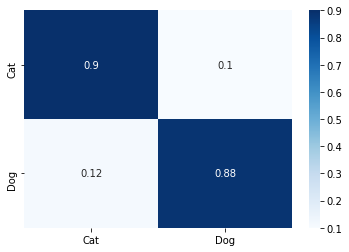

In [48]:
con_matrix = np.asarray([[2250, 250], [288, 2212]])/2500
sns.heatmap(con_matrix, annot=True, xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'], cmap='Blues')